<a href="https://colab.research.google.com/github/mmillet88/russian_therapy/blob/main/empathy_classifier_distilrubert_tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libaries

In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers import (
    glue_tasks_num_labels,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    GlueDataset,
    GlueDataTrainingArguments,
    TrainingArguments,
)
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
import gc

import datasets
from datasets import load_dataset
from datasets import DatasetDict

import numpy as np
from numpy.lib.function_base import average

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
# only run for Hyperparameter tuning

!pip install ray torch torchvision
from ray import tune

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.examples.pbt_transformers.utils import (
    download_data,
    build_compute_metrics_fn,
)
from ray.tune.schedulers import PopulationBasedTraining

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# only run for baseline model - transformers as feature extractors

!pip install umap-learn==0.5.2

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading datasets and converting into Dataset class (Huggingface library)

## Downloading data

In [ ]:

!mkdir emp_chatbot
!mkdir emp_chatbot/data

mkdir: cannot create directory ‘emp_chatbot’: File exists
mkdir: cannot create directory ‘emp_chatbot/data’: File exists


In [ ]:
# Downloading datasets: empathy_dataset - crowdsorced dataset Yandex.toloka

os.chdir('/content/emp_chatbot/data')
!gdown --id 1fMQBLfyuQrjpzd3TGyr0FWeiPmIXgZzC


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fMQBLfyuQrjpzd3TGyr0FWeiPmIXgZzC
To: /content/emp_chatbot/data/empathy_dataset.json
100% 338k/338k [00:00<00:00, 113MB/s]


## Assembling a Dataset class and creating train/test/validation splits for both cedr(augmented)  and epru datasets

In [ ]:
# Assembling a Dataset class for both augmented CEDR and EPRU

data_files = {"train": ["empathy_dataset.json"]}
empathy_dataset = load_dataset('json', data_files=data_files)
empathy_dataset.shuffle(seed=42)
# seed 42!head -n 102 emotions_utterances.csv

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-3e89b10916b30978/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['utterance', 'label'],
        num_rows: 787
    })
})

In [ ]:
# create a train/validation/test set seed 200

train_validation_test = empathy_dataset['train'].train_test_split(shuffle=True, seed=50, test_size=0.3)

validation_test = train_validation_test['test'].train_test_split(shuffle=True, seed=50, test_size=0.5)


empathy_dataset = DatasetDict({
    'train': train_validation_test['train'],
    'validation': validation_test['train'],
    'test': validation_test['test']})



## Filtering augmented cedr dataset

In [ ]:
train_ds = empathy_dataset['train']
train_ds[5]

{'utterance': 'Что значит мучение. На мой взгляд у тебя все в порядке. Не наговаривай на свое здоровье',
 'label': 'low'}

In [ ]:
print(train_ds.features)

{'utterance': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}


In [ ]:
# Adding a column with punctuation removed

def remove_punctuation(row):
  punctuation = ')£;-(:,?!'
  text_no_punct = ''.join([element for element in row['utterance'] if element not in punctuation])
  return {'text_no_punct': text_no_punct.lower()}
empathy_dataset = empathy_dataset.map(remove_punctuation)

# inspecting features

  0%|          | 0/550 [00:00<?, ?ex/s]

  0%|          | 0/118 [00:00<?, ?ex/s]

  0%|          | 0/119 [00:00<?, ?ex/s]

In [ ]:
# encoding label as a class

empathy_dataset = empathy_dataset.class_encode_column('label')

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# checking that label column is inded of ClassLabel type

empathy_dataset['train'].features

{'utterance': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=3, names=['high', 'low', 'medium'], id=None),
 'text_no_punct': Value(dtype='string', id=None)}

In [ ]:
empathy_dataset['train'].features

{'utterance': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=3, names=['high', 'low', 'medium'], id=None),
 'text_no_punct': Value(dtype='string', id=None)}

## Class Distribution visualisation

In [ ]:
# from Dataset to DataFrame for cedr

empathy_dataset.set_format(type='pandas')
df = empathy_dataset['train'][:]
df.head()

,utterance,label,text_no_punct
0,Не переживайте. Это не конец мира. Всё наладит...,2,не переживайте. это не конец мира. всё наладит...
1,"я услышал,теперь задам вопросы про брата",1,я услышалтеперь задам вопросы про брата
2,Расскажи мне чуть подробнее об этом.,1,расскажи мне чуть подробнее об этом.
3,"Уверен, это временное явление. Хочешь поговори...",1,уверен это временное явление. хочешь поговорит...
4,"Хорошо, могу я кое-что еще у вас уточнить?",1,хорошо могу я коечто еще у вас уточнить


In [ ]:
# adding a label_name column

def label_int2str(row):
  return empathy_dataset['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,utterance,label,text_no_punct,label_name
0,Не переживайте. Это не конец мира. Всё наладит...,2,не переживайте. это не конец мира. всё наладит...,medium
1,"я услышал,теперь задам вопросы про брата",1,я услышалтеперь задам вопросы про брата,low
2,Расскажи мне чуть подробнее об этом.,1,расскажи мне чуть подробнее об этом.,low
3,"Уверен, это временное явление. Хочешь поговори...",1,уверен это временное явление. хочешь поговорит...,low
4,"Хорошо, могу я кое-что еще у вас уточнить?",1,хорошо могу я коечто еще у вас уточнить,low


In [ ]:
df['label_name'].value_counts(ascending=True)

high      170
medium    185
low       195
Name: label_name, dtype: int64

### Plotting labels distribution

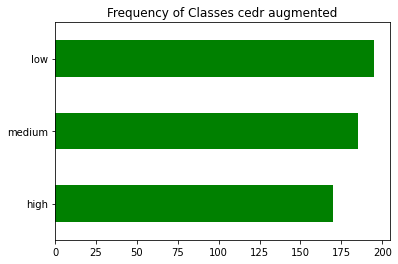

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh(color='green')
plt.title('Frequency of Classes cedr augmented')
plt.show()

### Plotting Length of sequence distribution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


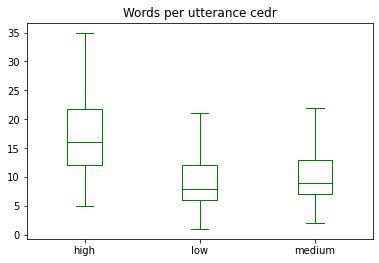

In [ ]:
df['Words per utterance cedr'] = df['utterance'].str.split().apply(len)
df.boxplot('Words per utterance cedr', by='label_name', grid=False, showfliers=False, color='green')
plt.suptitle('')
plt.xlabel('')
plt.show()

Resetting the format of Emotions dataset from dataframe to datasetDictionary

In [ ]:
empathy_dataset.reset_format()


# Tokenization

In [ ]:
# loading a tokenizer corresponding to the model

models = ['cointegrated/rubert-tiny2', 'DeepPavlov/rubert-base-cased', 'DeepPavlov/distilrubert-tiny-cased-conversational-v1']
model_ckpt = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# tokenizing the full dataset as a single batch. Two versions: with and without punctuation

def tokenize(batch):
  return tokenizer(batch['utterance'], padding=True, truncation=True)

def tokenize_no_punct(batch):
  return tokenizer(batch['text_no_punct'], padding=True, truncation=True)

empathy_dataset_encoded = empathy_dataset.map(tokenize, batched=True, batch_size=None)
empathy_dataset_no_punct_encoded = empathy_dataset.map(tokenize_no_punct, batched=True, batch_size=None)


# print(emotions_encoded['train'].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# inspecting new feaures of the dataset: input ids, attention_mask

empathy_dataset_encoded.items()

dict_items([('train', Dataset({
    features: ['utterance', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 550
})), ('validation', Dataset({
    features: ['utterance', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 118
})), ('test', Dataset({
    features: ['utterance', 'label', 'text_no_punct', 'input_ids', 'attention_mask'],
    num_rows: 119
}))])

### Exploring tokens class

In [ ]:
encoded_text = tokenizer('tokenising -  это очень важно!')
print(encoded_text)
encoded_text.items()

{'input_ids': [2, 2824, 20045, 252, 1499, 1931, 45, 426, 675, 2370, 67, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


dict_items([('input_ids', [2, 2824, 20045, 252, 1499, 1931, 45, 426, 675, 2370, 67, 3]), ('attention_mask', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'to', '##ke', '##n', '##is', '##ing', '-', 'это', 'очень', 'важно', '!', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenising - это очень важно! [SEP]


In [ ]:
print(tokenizer.vocab_size)

30522


In [ ]:
# names of the fields that the model expects in the forward pass

tokenizer.model_input_names

['input_ids', 'attention_mask']

# Training emotions classifier

## Transformers as Feature Extractors

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def extract_hidden_states(batch):
  # place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # exract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # return vector for CLS token
  return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [ ]:
empathy_dataset_encoded.set_format('torch', columns=['label','input_ids', 'attention_mask'])

In [ ]:
empathy_dataset_hidden = empathy_dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
empathy_dataset_hidden['test'].column_names

['utterance',
 'label',
 'text_no_punct',
 'input_ids',
 'attention_mask',
 'hidden_state']

### Creating a feature matrix

In [ ]:
X_train = np.array(empathy_dataset_hidden['train']['hidden_state'])
X_valid = np.array(empathy_dataset_hidden['validation']['hidden_state'])
y_train = np.array(empathy_dataset_hidden['train']['label'])
y_valid = np.array(empathy_dataset_hidden['validation']['label'])
X_train.shape, X_valid.shape

((550, 264), (118, 264))

### Visualising the training set

In [ ]:
# Scale features to 0,1 range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialise and fit umap
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,7.623222,12.639516,2
1,7.310437,5.576239,1
2,5.804595,8.887174,1
3,1.826090,8.715598,1
4,2.048180,8.561416,1


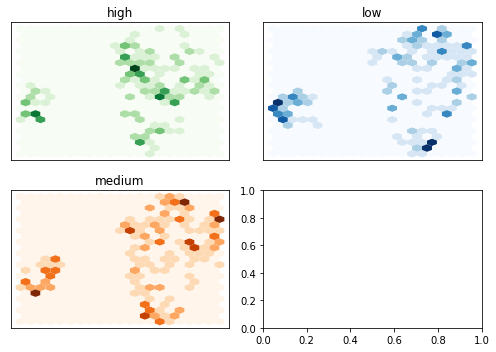

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greens', 'Blues', 'Oranges']
labels = empathy_dataset['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier - logistic regression (fast and does not require GPU)

In [ ]:
# Transformer basemodel embeddings logistic regression

lr_clf = LogisticRegression(max_iter=3000) #guarantees convergence
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6271186440677966

In [ ]:
# most_frequent class classifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.3644067796610169

Investigate the performance with a confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

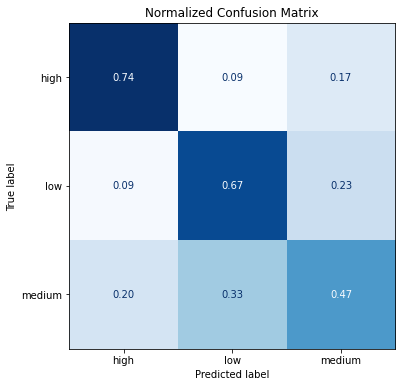

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
f1_score(y_valid, y_preds, average='macro')

0.6260287809602878

## Fine-tuning on EDRu


In [ ]:
# optional - loging into huggingface to save the model
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 and are newly initialized

In [ ]:
# specifying metrics for performance evaluation

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  prec = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': recall}

### Hyperparameter search

In [ ]:
def model_init():
    """Returns an initialized model for use in a Hugging Face Trainer."""
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
    model = model.to('cuda')
    return model

batch_size = 64
logging_steps = len(empathy_dataset['train']) // batch_size
model_name = f"{model_ckpt}_empathy_classifier"
training_args = TrainingArguments(output_dir=f'/content/drive/MyDrive/chatbot/{model_name}/',
                                  num_train_epochs=15,
                                  learning_rate =2e-5,
                                  adam_epsilon=1e-6,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'f1', # addition
                                  load_best_model_at_end = True,
                                  logging_dir="./logs")

import torch.nn as nn
trainer = Trainer(model_init=model_init, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=empathy_dataset_encoded['train'],
                  eval_dataset=empathy_dataset_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

In [ ]:
reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
    },
    metric_columns=["eval_acc", "eval_loss", "eval_f1", "epoch", "training_iteration"],
)

In [ ]:

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
# specifying hyperparameters to run through

tune_config = {
    "learning_rate": tune.choice([1e-5, 2e-5, 1e-4]),
    "weight_decay": tune.choice([0.01, 0.1, 0.2]),
    "adam_epsilon": tune.choice([1e-6,1e-8, 1e-4])
}
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray",
    hp_space=lambda _: tune_config,
    progress_reporter=reporter, local_dir="~/ray_results/", #local_dir="/content/drive/MyDrive/chatbot/ray_results/", #local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        log_to_file=True,)

### Training


In [ ]:
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         # forward pass
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 2.0, 1.0, 1.0]))
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss


In [ ]:
cleanup()

In [ ]:
batch_size = 64
logging_steps = len(empathy_dataset['train']) // batch_size
model_name = f"{model_ckpt}_empathy_preprocessed_punct_lowercasing"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate =1e-4,
                                  adam_epsilon=1e-4, 
                                  #1e-06,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error',
                                  metric_for_best_model = 'f1', # addition
                                  load_best_model_at_end = True)
                                  #logging_dir="./logs")


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=empathy_dataset_encoded['train'],
                  eval_dataset=empathy_dataset_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091100,1.064115,0.533898,0.524847,0.526105,0.533898
2,1.046800,0.999371,0.533898,0.512683,0.520265,0.533898
3,0.983200,0.915760,0.525424,0.509460,0.512167,0.525424
4,0.902700,0.888525,0.550847,0.515539,0.571869,0.550847
5,0.886000,0.838715,0.559322,0.545875,0.564413,0.559322
6,0.847200,0.763886,0.644068,0.631622,0.632643,0.644068
7,0.796500,0.754007,0.627119,0.617591,0.628726,0.627119
8,0.733400,0.727395,0.694915,0.682506,0.697337,0.694915
9,0.698600,0.678868,0.720339,0.716072,0.717530,0.720339
10,0.650800,0.703819,0.677966,0.664744,0.686483,0.677966


TrainOutput(global_step=180, training_loss=0.6975533419185215, metrics={'train_runtime': 23.5943, 'train_samples_per_second': 466.214, 'train_steps_per_second': 7.629, 'total_flos': 10463091606000.0, 'train_loss': 0.6975533419185215, 'epoch': 20.0})

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=empathy_dataset_no_punct_encoded['train'],
                  eval_dataset=empathy_dataset_no_punct_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

trainer.train()

Cloning https://huggingface.co/mmillet/distilrubert-tiny-cased-conversational-v1_empathy_preprocessed_punct_lowercasing into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095300,1.069229,0.466102,0.373979,0.374029,0.466102
2,1.066000,1.024152,0.559322,0.549085,0.544556,0.559322
3,1.011900,0.925931,0.610169,0.610572,0.614714,0.610169
4,0.911800,0.865939,0.584746,0.534919,0.583489,0.584746
5,0.892100,0.792527,0.635593,0.613331,0.627490,0.635593
6,0.830000,0.777579,0.627119,0.608724,0.619924,0.627119
7,0.801500,0.767485,0.669492,0.660095,0.687069,0.669492
8,0.733400,0.713316,0.677966,0.665863,0.674782,0.677966
9,0.696000,0.693902,0.686441,0.675811,0.683276,0.686441
10,0.634900,0.655506,0.711864,0.705674,0.708500,0.711864


Adding files tracked by Git LFS: ['vocab.txt']. This may take a bit of time if the files are large.


TrainOutput(global_step=180, training_loss=0.6867494463920594, metrics={'train_runtime': 28.8409, 'train_samples_per_second': 381.403, 'train_steps_per_second': 6.241, 'total_flos': 10033101540000.0, 'train_loss': 0.6867494463920594, 'epoch': 20.0})

### Evaluating on valuation dataset

In [ ]:
preds_output = trainer.predict(empathy_dataset_encoded['validation'])
preds_output.metrics

{'test_loss': 0.7395163178443909,
 'test_accuracy': 0.7372881355932204,
 'test_f1': 0.7234174428875136,
 'test_precision': 0.7481191002561673,
 'test_recall': 0.7372881355932204,
 'test_runtime': 0.1148,
 'test_samples_per_second': 1028.15,
 'test_steps_per_second': 17.426}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = empathy_dataset_encoded['train'].features['label'].names

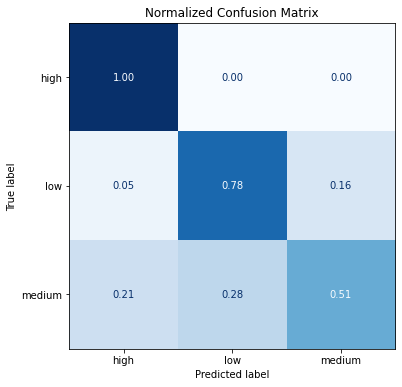

In [ ]:
# Extracting predicted vs valid labels to plot a confusion matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = empathy_dataset_encoded['train'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

### preprocessed


In [ ]:
preds_output = trainer.predict(empathy_dataset_no_punct_encoded['validation'])
preds_output.metrics

{'test_loss': 0.6582033634185791,
 'test_accuracy': 0.7288135593220338,
 'test_f1': 0.7228085357874074,
 'test_precision': 0.7245762711864406,
 'test_recall': 0.7288135593220338,
 'test_runtime': 0.0498,
 'test_samples_per_second': 2369.504,
 'test_steps_per_second': 40.161}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = empathy_dataset_no_punct_encoded['train'].features['label'].names

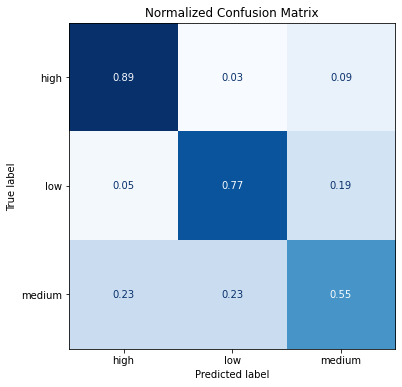

In [ ]:
# Extracting predicted vs valid labels to plot a confusion matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids
labels = empathy_dataset_no_punct_encoded['train'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

### Evaluating on test dataset

In [ ]:
test_preds_output = trainer.predict(empathy_dataset_encoded['test'])
test_preds_output.metrics

{'test_loss': 0.6382144093513489,
 'test_accuracy': 0.7142857142857143,
 'test_f1': 0.7154452563814827,
 'test_precision': 0.7246998997357678,
 'test_recall': 0.7142857142857143,
 'test_runtime': 0.0597,
 'test_samples_per_second': 1994.494,
 'test_steps_per_second': 33.521}

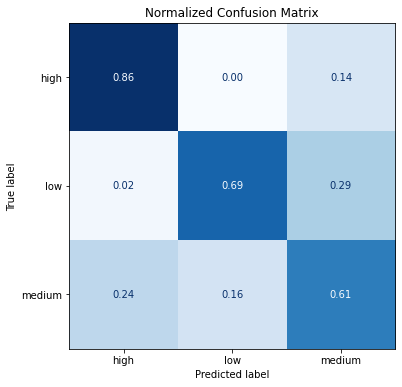

In [ ]:
y_preds = np.argmax(test_preds_output.predictions, axis=1)
y_valid = test_preds_output.label_ids
labels = empathy_dataset_encoded['train'].features['label'].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
test_preds_output = trainer.predict(empathy_dataset_no_punct_encoded['test'])
test_preds_output.metrics

{'test_loss': 0.6076758503913879,
 'test_accuracy': 0.7478991596638656,
 'test_f1': 0.7513707271526497,
 'test_precision': 0.7652935299994124,
 'test_recall': 0.7478991596638656,
 'test_runtime': 0.0751,
 'test_samples_per_second': 1584.002,
 'test_steps_per_second': 26.622}

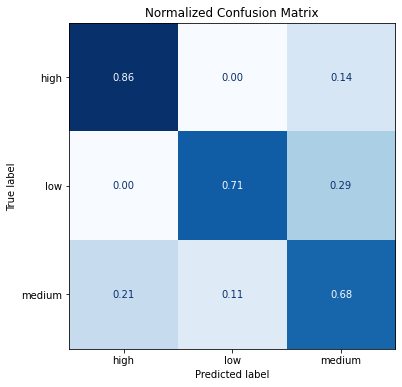

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()
y_preds = np.argmax(test_preds_output.predictions, axis=1)
y_valid = test_preds_output.label_ids
labels = empathy_dataset_no_punct_encoded['train'].features['label'].names
plot_confusion_matrix(y_preds, y_valid, labels)

### Error Analysis - Create a DataFrame with the texts, losses and predicted/true labels

In [ ]:
# Create a DataFrame with the texts, losses and predicted/true labels

def forward_pass_with_label(batch):
  #Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device),
                         reduction="none")
    # Place outputs on the GPU for compatibility with other dataset columns
    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}      

In [ ]:
# Convert dataset back to Pytorch tensors
empathy_dataset_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Comput loss function
empathy_dataset_encoded['test'] = empathy_dataset_encoded['test'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
empathy_dataset_encoded.set_format('pandas')
cols = ['utterance', 'label', 'predicted_label', 'loss']
df_test = empathy_dataset_encoded['test'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [ ]:
df_test.sort_values('loss', ascending=False).head(10)

,utterance,label,predicted_label,loss
86,"Да, прекрасно понимаю. Нынче не совсем спокойн...",high,medium,3.209799
72,"Думаю, что Вам в Ваших проблемах весьма помогл...",low,high,3.108995
104,"Посоветую Вам верить, ждать и надеется на лучш...",medium,high,2.260969
28,"Нужно найти дело, которое бы приносило положит...",low,medium,2.122168
80,"Понял Вашу проблему. Хочу спросить, как давно ...",low,medium,1.991438
19,"Я сожалею, что с Вами произошло такое. Я попро...",medium,high,1.937361
2,может расскажешь о своих проблемах и возможно ...,low,medium,1.888247
108,Рад придти вам на помощь и надеюсь мой опыт бы...,medium,high,1.843785
63,"Великолепно, но если что, то обращайся. Рад за...",high,medium,1.754505
110,"Вам одиноко от того, что близкие люди находятс...",medium,high,1.725028


In [ ]:
df_test.sort_values('loss', ascending=True).head(10)

,utterance,label,predicted_label,loss
115,"Добрый день. Хорошо, что Вы обратились именно ...",high,high,0.082090
92,"Мне очень жаль, соболезную. Я могу тебе чем-то...",high,high,0.085731
31,"Это очень хорошо, что вы откровенны со мной. Я...",high,high,0.086590
103,"Я очень хорошо Вас понимаю и сочувствую Вам, д...",high,high,0.089011
48,"Спасибо, что поделились своими чувствами. Мне ...",high,high,0.090997
29,"Я вас очень понимаю, выдимо с кем-то из ваших ...",high,high,0.093616
78,"Я уверен, что это временное явление. Что-то пр...",high,high,0.100231
0,"Я очень переживаю за вас , и с большой радость...",high,high,0.105338
33,"Приятно, что вы доверили мне свою проблему, я ...",high,high,0.106517
3,Я тебя понимаю. И хочу помочь. Давай все обсуд...,high,high,0.111382


In [ ]:
# Convert dataset back to Pytorch tensors
empathy_dataset_no_punct_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Comput loss function
empathy_dataset_no_punct_encoded['test'] = empathy_dataset_no_punct_encoded['test'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
empathy_dataset_no_punct_encoded.set_format('pandas')
cols = ['utterance', 'label', 'predicted_label', 'loss']
df_test = empathy_dataset_no_punct_encoded['test'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [ ]:
df_test.sort_values('loss', ascending=False).head(10)

,utterance,label,predicted_label,loss
86,"Да, прекрасно понимаю. Нынче не совсем спокойн...",high,medium,3.404076
72,"Думаю, что Вам в Ваших проблемах весьма помогл...",low,medium,2.707313
9,"Да, проблема. Давай попробую помочь тебе прийт...",high,medium,2.638943
2,может расскажешь о своих проблемах и возможно ...,low,medium,2.498707
19,"Я сожалею, что с Вами произошло такое. Я попро...",medium,high,2.099926
104,"Посоветую Вам верить, ждать и надеется на лучш...",medium,high,2.081212
50,Я Вас поняла и обязательно Вам помогу. Давайте...,medium,high,2.018775
108,Рад придти вам на помощь и надеюсь мой опыт бы...,medium,high,1.991944
63,"Великолепно, но если что, то обращайся. Рад за...",high,medium,1.873199
100,Вы пробовали искать работу? Что Вас интересует...,low,medium,1.805750


In [ ]:
df_test.sort_values('loss', ascending=True).head(10)

,utterance,label,predicted_label,loss
33,"Приятно, что вы доверили мне свою проблему, я ...",high,high,0.109372
29,"Я вас очень понимаю, выдимо с кем-то из ваших ...",high,high,0.113781
103,"Я очень хорошо Вас понимаю и сочувствую Вам, д...",high,high,0.114411
3,Я тебя понимаю. И хочу помочь. Давай все обсуд...,high,high,0.116149
27,Спасибо Вам за открытость и честность. Я Вас п...,high,high,0.116191
48,"Спасибо, что поделились своими чувствами. Мне ...",high,high,0.117491
31,"Это очень хорошо, что вы откровенны со мной. Я...",high,high,0.117551
115,"Добрый день. Хорошо, что Вы обратились именно ...",high,high,0.118818
32,я очень рад за вашу открытость.все наладиться ...,high,high,0.122414
8,"Обычно только у кого всё плохо, говорят обратное.",low,low,0.123712


### Saving model

In [ ]:
trainer.push_to_hub(commit_message='distilrubert  finetuned on preprocessed punct lower empathy_dataset')

Upload file pytorch_model.bin:   0%|          | 3.34k/39.6M [00:00<?, ?B/s]

Upload file runs/Aug25_08-58-13_ae6d05f31d28/events.out.tfevents.1661417919.ae6d05f31d28.1289.0:  20%|##      …

To https://huggingface.co/mmillet/distilrubert-tiny-cased-conversational-v1_empathy_preprocessed_punct_lowercasing
   307fc2a..1a6ce0c  main -> main

   307fc2a..1a6ce0c  main -> main

To https://huggingface.co/mmillet/distilrubert-tiny-cased-conversational-v1_empathy_preprocessed_punct_lowercasing
   1a6ce0c..4f0fb1b  main -> main

   1a6ce0c..4f0fb1b  main -> main



'https://huggingface.co/mmillet/distilrubert-tiny-cased-conversational-v1_empathy_preprocessed_punct_lowercasing/commit/1a6ce0c8995b6c48fe1f25c4b15ae567648dbb61'

### Testing model

In [ ]:
# testing
# model_n = model_name.split('/')[1]
# model_id=f'mmillet/{model_n}'
model_id = "mmillet/distilrubert-tiny-cased-conversational-v1_single_finetuned_empathy_classifier"
classifier = pipeline('text-classification', model=model_id)
custom_sentence = "Скажите, пожалуйста, ваша тревога вызвана" 
preds = classifier(custom_sentence, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
preds

[{'label': 'LABEL_0', 'score': 0.05862347036600113},
 {'label': 'LABEL_1', 'score': 0.2921987473964691},
 {'label': 'LABEL_2', 'score': 0.6491777896881104}]

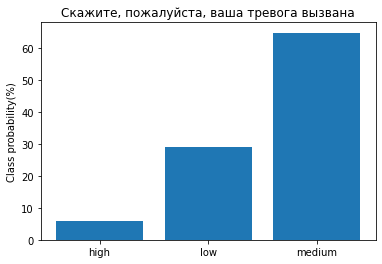

In [ ]:
# visualising prediction
preds_df = pd.DataFrame(preds)
plt.bar(labels, 100 * preds_df['score'])
plt.title(f"{custom_sentence}")
plt.ylabel('Class probability(%)')
plt.show()
